In [0]:
# simple generative adversarial network
# this version uses a very simple neural network
# aim is to see the adversarial concept working

In [0]:
# conventional PyTorch imports
import torch
import torch.nn as nn
#import torch.nn.functional as F

In [0]:
import random
import pandas

In [0]:
import numpy
import matplotlib.pyplot as plt

In [0]:
# function to generate real data
# generates a 2d array with values for a gaussian lump

def generate_real(x, y, s, h):
  # x, y is the location of a lump
  # s is the spread
  # h is the amplitude
  xvalues, yvalues = numpy.meshgrid(numpy.linspace(-10,10,100), numpy.linspace(-10,10,100))
  
  #  lump
  d = numpy.sqrt(numpy.square(xvalues - x) + numpy.square(yvalues - y))
  g = h * numpy.exp(-( (d)**2 / ( 2.0 * s**2 ) ) )
  
  # return binomial sampling scaled also by the distribution
  return torch.FloatTensor(numpy.random.binomial(n=1, p=g) * g)


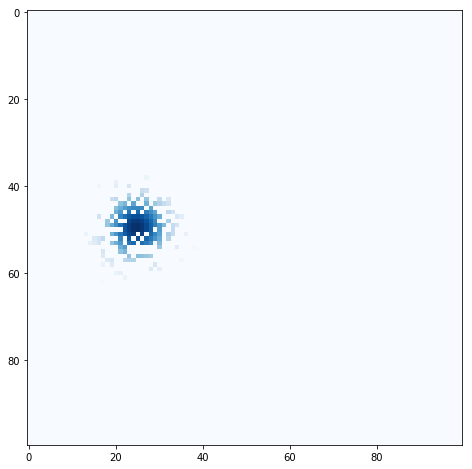

In [5]:
# demonstrate generation of real data distribution
d = generate_real(-5, 0, 1, 1)
#d = generate_real(5, 0, 1, 1)

plt.figure(figsize = (16,8))
plt.imshow(d, interpolation='none', cmap='Blues')


In [0]:
# function to generate uniform random data

def generate_random(shape):
  t = torch.randn(shape)
  return t

In [0]:
# from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [0]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View((1, 10000)),
            
            nn.Linear(10000, 100),
            #nn.Sigmoid(),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate error
        loss = self.error_function(outputs, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [97]:
%%time 

# create Discriminator and test it

D = Discriminator()

# train Discriminator

sign = 1

for i in range(2000):
  
  # train discriminator on real data
  D.train(generate_real(5 * sign, 0, 1, 1),
          torch.FloatTensor([1.0]).view(1,1))

  # train discriminator on false (random) data
  D.train(generate_random((100,100)),
          torch.FloatTensor([0.0]).view(1,1))
  
  # flip sign
  sign *= -1
  pass


CPU times: user 37.9 s, sys: 1.17 s, total: 39.1 s
Wall time: 39.3 s


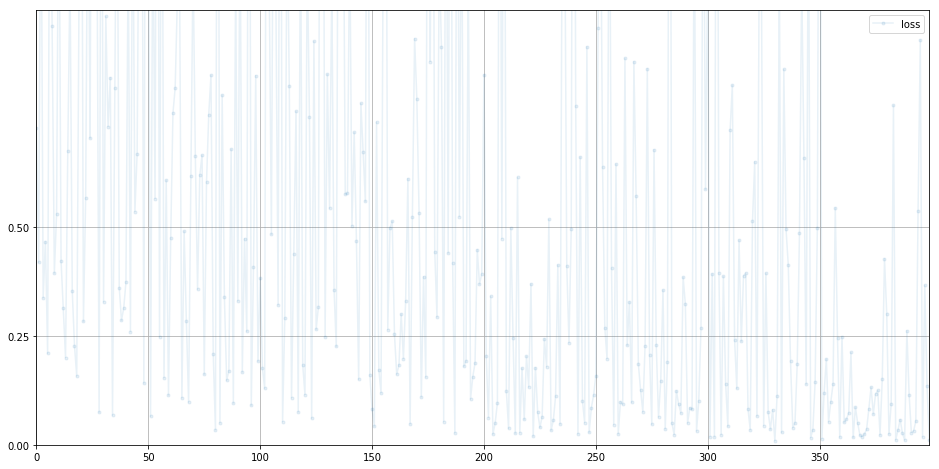

In [98]:
# plot discriminator error

D.plot_progress()

In [116]:
# manually check D can indeed discriminate between real and fake data

print(D.forward(generate_random((100,100))).item())
print(D.forward(generate_random((100,100))).item())
print(D.forward(generate_random((100,100))).item())
print(D.forward(generate_random((100,100))).item())
print("")
print(D.forward(generate_real(-5, 0, 1, 1)).item())
print(D.forward(generate_real(-5, 0, 1, 1)).item())
print(D.forward(generate_real(-5, 0, 1, 1)).item())
print(D.forward(generate_real(-5, 0, 1, 1)).item())
print("")
print(D.forward(generate_real(5, 0, 1, 1)).item())
print(D.forward(generate_real(5, 0, 1, 1)).item())
print(D.forward(generate_real(5, 0, 1, 1)).item())
print(D.forward(generate_real(5, 0, 1, 1)).item())


0.9238060712814331
0.8475555181503296
0.321616530418396
0.6430159211158752

0.9998844861984253
0.9998902082443237
0.9998961687088013
0.9998949766159058

0.9999014139175415
0.9998959302902222
0.9998929500579834
0.9998993873596191


In [0]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View((1,100)),
            
            nn.Linear(100, 500),
            #nn.Sigmoid(),
            nn.LeakyReLU(0.2),
            
            nn.LayerNorm(500),
            
            nn.Linear(500, 10000),
            nn.Sigmoid(),
            
            View((100,100))
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.error_function(d_output, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 100 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_images(self):
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random((10,10))).detach().cpu().numpy(), interpolation='none', cmap='Blues')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 2.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

torch.Size([100, 100])


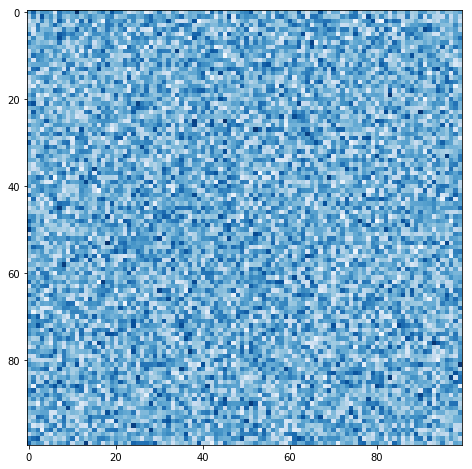

In [102]:
# scratch

G = Generator()

print(G(generate_random(100).view(10, 10)).shape)

plt.figure(figsize = (16,8))
    
plt.imshow(G.forward(generate_random((10,10))).detach().cpu().numpy(), 
           interpolation='none',
           cmap='Blues')

In [0]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()

In [117]:
%%time 

# train Discriminator and Generator

sign = 1

for i in range(8000):
  
    # train discriminator on real data
    D.train(generate_real(5 * sign, 0, 1, 1),
            torch.FloatTensor([1.0]).view(1,1))
    
    # train discriminator on false
    # use detach() so only D is updated, not G
    # label softening doesn't apply to 0 labels
    D.train(G.forward(generate_random((10,10))).detach(),
            torch.FloatTensor([0.0]).view(1,1))

    # train generator
    G.train(D, generate_random((10,10)),
            torch.FloatTensor([1.0]).view(1,1))
    
    # flip sign
    sign *= -1

    pass


counter =  2100
counter =  2200
counter =  2300
counter =  2400
counter =  2500
counter =  2600
counter =  2700
counter =  2800
counter =  2900
counter =  3000
counter =  3100
counter =  3200
counter =  3300
counter =  3400
counter =  3500
counter =  3600
counter =  3700
counter =  3800
counter =  3900
counter =  4000
counter =  4100
counter =  4200
counter =  4300
counter =  4400
counter =  4500
counter =  4600
counter =  4700
counter =  4800
counter =  4900
counter =  5000
counter =  5100
counter =  5200
counter =  5300
counter =  5400
counter =  5500
counter =  5600
counter =  5700
counter =  5800
counter =  5900
counter =  6000
counter =  6100
counter =  6200
counter =  6300
counter =  6400
counter =  6500
counter =  6600
counter =  6700
counter =  6800
counter =  6900
counter =  7000
counter =  7100
counter =  7200
counter =  7300
counter =  7400
counter =  7500
counter =  7600
counter =  7700
counter =  7800
counter =  7900
counter =  8000
counter =  8100
counter =  8200
counter 

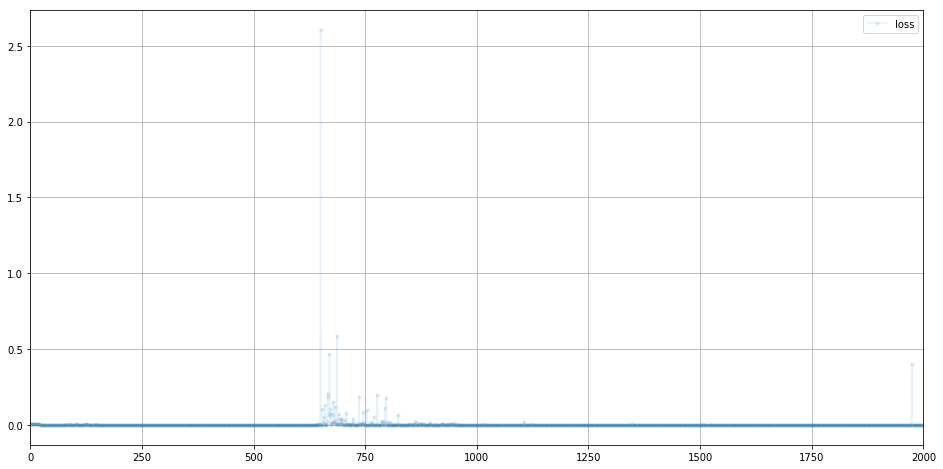

In [122]:
# plot discriminator error

#D.plot_progress()

df = pandas.DataFrame(D.progress, columns=['loss'])
df.plot(figsize=(16,8), alpha=0.1, marker='.', grid=True)

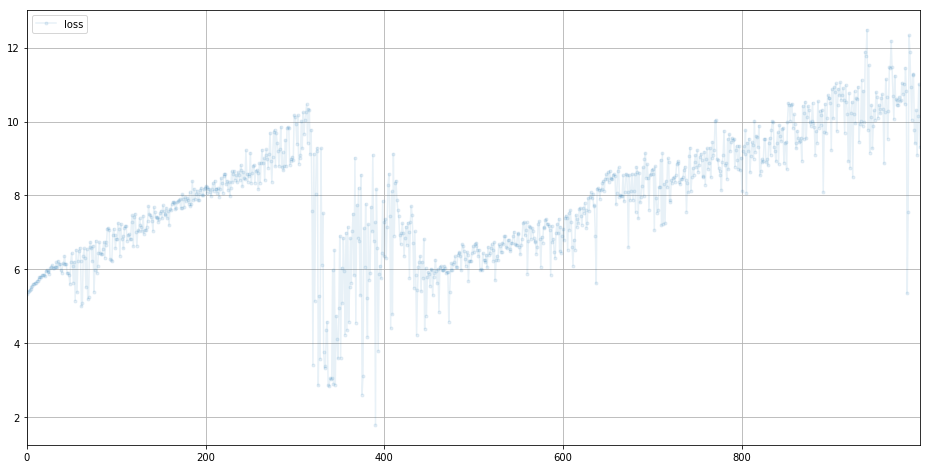

In [123]:
# plot generator error

#G.plot_progress()

df = pandas.DataFrame(G.progress, columns=['loss'])
df.plot(figsize=(16,8), alpha=0.1, marker='.', grid=True)

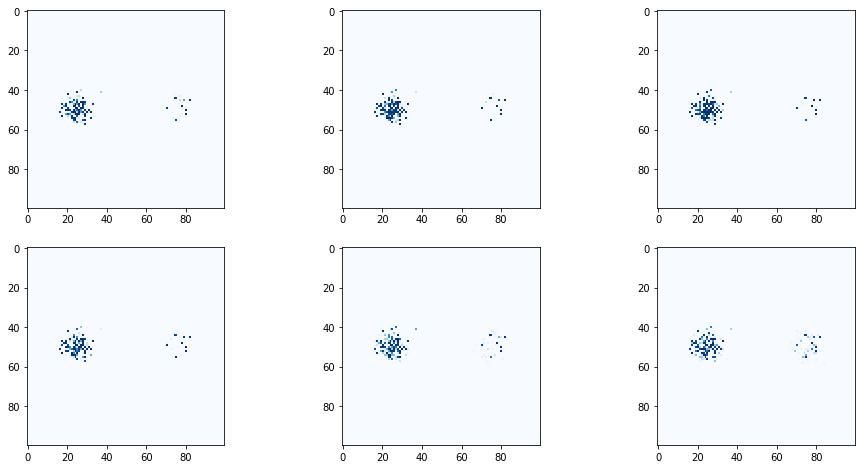

In [124]:
# show generator output

G.plot_images()

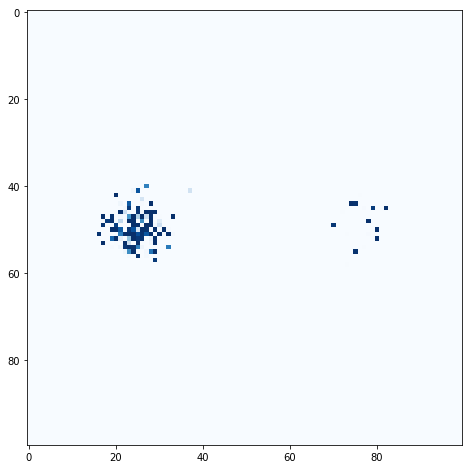

In [125]:
## expts

seed = torch.zeros(100)
seed[random.randint(0,99)] = 1

plt.figure(figsize = (16,8))
plt.imshow(G.forward(seed.view(10,10)).detach().cpu().numpy(), 
           interpolation='none',
           cmap='Blues')